# **[Week14] Diffusion Model**
## **Objectives**
- Understanding the principles of the diffusion model.
- Implementing the diffusion algorithm.
- (Optional) Utilizing a pretrained model to generate high-quality images using prompts.

## **Backgrounds on Diffusion Model**

In today's practice session, we will focus on how the algorithm of the diffusion model is derived and then implement it.

In diffusion model, the forward process introduces random disturbances at each step, causing the input image to eventually become mostly noise. But if we can undo this process, we might be able to retrieve the original image from the noise.

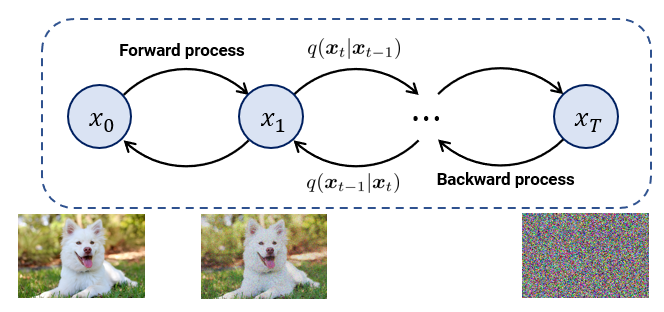

Before we begin, let me introduce a few preliminary and assumptions.

**Forward Process**: 

- In forward process we inject the noise at each time step $t$, where the noise is sampled from Gaussian distribution, i.e., $q(\boldsymbol{x}_t \vert \boldsymbol{x}_{t-1}) = \mathcal{N}(\sqrt{1-\beta_t} \boldsymbol{x}_{t-1}, \beta_t \mathbf{I})$. In other words, $\boldsymbol{x}_t = \sqrt{1-\beta_t} \boldsymbol{x}_{t-1} + \sqrt{\beta_t}\epsilon$ $~~ \text{where} ~~$ $\epsilon \sim \mathcal{N}(0, \mathbf{I})$.

- Moreover, the forward process is assumed to be Markov process, where the sample at time $t$ only depends on that of  time $t-1$. In other words, $q(\boldsymbol{x}_t\vert \boldsymbol{x}_{t-1}, \boldsymbol{x}_{t-2}, \dots, \boldsymbol{x}_{0})=q(\boldsymbol{x}_t\vert \boldsymbol{x}_{t-1})$.

Then we can derive the probability distribution of $x_t$ given the original image $x_0$ as follows.

\begin{equation}
\boldsymbol{x}_t = \sqrt{\bar{\alpha}_t} \boldsymbol{x}_0 + \sqrt{1-\bar{\alpha}_t}\epsilon  ~~\text{  where }~~ \epsilon \sim \mathcal{N}(0, \mathbf{I}), ~~ \bar{\alpha}_t = \prod_{i=1}^{t}\alpha_t ~~\text{and}~~ \alpha_t = 1-\beta_t.
\end{equation}

This equation implies that instead of injecting noise $t$ times to obtain the noised image corresponding to time step $t$ in forward process, we can obtain the $t$-th noised image with **only a single injection of noise**.

**Backward Process**

- When we reverse the above process that turned an image into noise, the reverse model has learned the original distribution of the image. This means that if we give a new noise input to the reverse model, it should generate a new image from the same original distribution.

- To be more specific, if we can infer $q(\boldsymbol{x}_{t-1}\vert \boldsymbol{x}_t)$, we can generate the original image $\boldsymbol{x}_0$ from noise $\boldsymbol{x}_T$ by sampling the image of the previous time step $t-1$ given that of $t$ successively.

- **Our objective here is to infer $q(\boldsymbol{x}_{t-1}\vert \boldsymbol{x}_t)$!**
    - **Unfortunately, $q(\boldsymbol{x}_{t-1}\vert \boldsymbol{x}_t)$ is not known to us in general.**

- Can we find any proxy instead of $q(\boldsymbol{x}_{t-1}\vert \boldsymbol{x}_t)$?

- To this end, we now make use of the following useful fact: **The backward process given the original image $\boldsymbol{x}_0$ also follows the Gaussian!**

- In other words, $q(\boldsymbol{x}_{t-1}\vert \boldsymbol{x}_t, \boldsymbol{x}_0) \sim \mathcal{N}(\cdot, \cdot)$ 


To see why this happens, we utilize the Bayes Rule as follows,

\begin{align}
q(\boldsymbol{x}_{t-1}\vert \boldsymbol{x}_t, \boldsymbol{x}_0) &= \frac{q(\boldsymbol{x}_{t}\vert \boldsymbol{x}_{t-1}, \boldsymbol{x}_0)q(\boldsymbol{x}_{t-1}\vert \boldsymbol{x}_0)}{q(\boldsymbol{x}_{t}\vert \boldsymbol{x}_0)}\\
&= \frac{q(\boldsymbol{x}_{t}\vert \boldsymbol{x}_{t-1})q(\boldsymbol{x}_{t-1}\vert \boldsymbol{x}_0)}{q(\boldsymbol{x}_{t}\vert \boldsymbol{x}_0)}
\end{align}

where the last equality is due to Markov process assumption in forward steps. As we've derived in the above Forward Process, all three probability distributions shown in the equation follow the Gaussian. By using this fact, one can derive $q(\boldsymbol{x}_{t-1}\vert \boldsymbol{x}_t, \boldsymbol{x}_0)$ as follows (The detailed proof can be found in https://arxiv.org/abs/2208.11970). 


\begin{equation}
q(\boldsymbol{x}_{t-1}\vert \boldsymbol{x}_t, \boldsymbol{x}_0) = \mathcal{N}\left(\frac{\sqrt{\alpha_t}\left(1-\bar{\alpha}_{t-1}\right) \boldsymbol{x}_t+\sqrt{\bar{\alpha}_{t-1}}\left(1-\alpha_t\right) \boldsymbol{x}_0}{1-\bar{\alpha}_t}, \frac{\left(1-\alpha_t\right)\left(1-\bar{\alpha}_{t-1}\right)}{1-\bar{\alpha}_t} \mathbf{I}\right)   ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ (1)
\end{equation}

By using the above distribution, now we can obtain $\boldsymbol{x}_{t-1}$ when we have $\boldsymbol{x}_{t}$. 


###**So, have we finished?**

The answer is of course **NO** :(

According to the equation (1), $\boldsymbol{x}_0$ needs to be given in order to obtain $\boldsymbol{x}_{t-1}$, which means we need to know the real image. However, in the actual generation step, $\boldsymbol{x}_0$ is unknown (in fact, it is the very target image we want to generate!) to us. Therefore, we cannot directly utilize $q(\boldsymbol{x}_{t-1}\vert \boldsymbol{x}_t, \boldsymbol{x}_0)$ in the actual sampling (generating) stage.

**Here, we would like to learn the backward process distribution $p_{\theta}(\boldsymbol{x}_{t-1}\vert \boldsymbol{x}_t)$, which is parameterized by $\theta$ and we can utilize without knowing the real image $\boldsymbol{x}_0$.**

- To achieve this, we update parameter $\theta$ to make $p_{\theta}(\boldsymbol{x}_{t-1}\vert \boldsymbol{x}_t)$ as close as possible to $q(\boldsymbol{x}_{t-1}\vert \boldsymbol{x}_t, \boldsymbol{x}_0)$.

- In other words, we desire to make $p_{\theta}(\boldsymbol{x}_{t-1}\vert \boldsymbol{x}_t) ≈ q(\boldsymbol{x}_{t-1}\vert \boldsymbol{x}_t, \boldsymbol{x}_0)$.

- Then we can generate $\boldsymbol{x}_{t-1}$ when given only $\boldsymbol{x}_t$ without accessing $\boldsymbol{x}_0$.



Now we consider the following optimization problem:

\begin{equation}
\min_{\theta} D_{\text{KL}}\left(q\left(\boldsymbol{x}_{t-1} \mid \boldsymbol{x}_t, \boldsymbol{x}_0\right) \| p_{\boldsymbol{\theta}}\left(\boldsymbol{x}_{t-1} \mid \boldsymbol{x}_t\right)\right)
\end{equation}

If we minimize the KL divergence above, we can make the two distributions become almost similar to each other.

**The remaining thing to do is to do the modeling the distribution $p_{\boldsymbol{\theta}}\left(\boldsymbol{x}_{t-1} \mid \boldsymbol{x}_t\right)$. Can we simplify the above optimization problem?**

Recall that 

\begin{equation}
\boldsymbol{x}_t = \sqrt{\bar{\alpha}_t} \boldsymbol{x}_0 + \sqrt{1-\bar{\alpha}_t}\boldsymbol{\epsilon}  ~~\text{  where }~~ \boldsymbol{\epsilon} \sim \mathcal{N}(0, \mathbf{I}) ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ (2)
\end{equation}

Regarding the equation (2), after rearranging the terms, we have

\begin{equation}
\boldsymbol{x}_0 =\frac{1}{\sqrt{\bar{\alpha}_t}} \boldsymbol{x}_t-\frac{\sqrt{\left(1-\bar{\alpha}_t\right)}}{\sqrt{\bar{\alpha}_t}} \boldsymbol{\epsilon}_0 ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ (3)
\end{equation}
where $\boldsymbol{\epsilon}_0$ is the noise that makes $\boldsymbol{x}_t$ from $\boldsymbol{x}_0$.

Substituting the equation (3) to the above equation (1), we can rewrite as (detailed derivation can be found in  https://arxiv.org/abs/2208.11970)

\begin{align}
q(\boldsymbol{x}_{t-1}\vert \boldsymbol{x}_t, \boldsymbol{x}_0) &= \mathcal{N}\left(\frac{\sqrt{\alpha_t}\left(1-\bar{\alpha}_{t-1}\right) \boldsymbol{x}_t+\sqrt{\bar{\alpha}_{t-1}}\left(1-\alpha_t\right) \boldsymbol{x}_0}{1-\bar{\alpha}_t}, \frac{\left(1-\alpha_t\right)\left(1-\bar{\alpha}_{t-1}\right)}{1-\bar{\alpha}_t} \mathbf{I}\right)\\
&= \mathcal{N}\left(\frac{1}{\sqrt{\alpha_t}} \boldsymbol{x}_t-\frac{1-\alpha_t}{\sqrt{1-\bar{\alpha}_t} \sqrt{\alpha_t}} \boldsymbol{\epsilon}_0, \frac{\left(1-\alpha_t\right)\left(1-\bar{\alpha}_{t-1}\right)}{1-\bar{\alpha}_t} \mathbf{I} \right)
\end{align}


### **Based on the above derivation, it is natural to model $p_{\boldsymbol{\theta}}\left(\boldsymbol{x}_{t-1} \vert \boldsymbol{x}_t\right)$ as the Gaussian distribution with mean $\frac{1}{\sqrt{\alpha_t}} \boldsymbol{x}_t-\frac{1-\alpha_t}{\sqrt{1-\bar{\alpha}_t} \sqrt{\alpha_t}} \boldsymbol{\epsilon}_\theta$ and the variance $\frac{\left(1-\alpha_t\right)\left(1-\bar{\alpha}_{t-1}\right)}{1-\bar{\alpha}_t} \mathbf{I}$,** where $\boldsymbol{\epsilon}_{\theta}$ is parameterized by $\theta$ and can be implemented with neural network!

- More specifically, $p_{\boldsymbol{\theta}}\left(\boldsymbol{x}_{t-1} \mid \boldsymbol{x}_t\right) = \mathcal{N}\left(\frac{1}{\sqrt{\alpha_t}} \boldsymbol{x}_t-\frac{1-\alpha_t}{\sqrt{1-\bar{\alpha}_t} \sqrt{\alpha_t}} \boldsymbol{\epsilon}_{\theta}(\boldsymbol{x}_t, t), \frac{\left(1-\alpha_t\right)\left(1-\bar{\alpha}_{t-1}\right)}{1-\bar{\alpha}_t} \mathbf{I} \right)$, where we implement $\boldsymbol{\epsilon}_{\theta}(\boldsymbol{x}_t, t)$ using neural network which receives $\boldsymbol{x}_t$ and  $t$ as inputs. 

- By using the fact that $D_{\mathrm{KL}}\left(\mathcal{N}\left(\boldsymbol{\mu}_x, \boldsymbol{\Sigma}_x\right) \| \mathcal{N}\left(\boldsymbol{\mu}_y, \boldsymbol{\Sigma}_y\right)\right)=\frac{1}{2}\left[\log \frac{\left|\boldsymbol{\Sigma}_y\right|}{\left|\boldsymbol{\Sigma}_x\right|}-d+\operatorname{tr}\left(\boldsymbol{\Sigma}_y^{-1} \boldsymbol{\Sigma}_x\right)+\left(\boldsymbol{\mu}_y-\boldsymbol{\mu}_x\right)^T \boldsymbol{\Sigma}_y^{-1}\left(\boldsymbol{\mu}_y-\boldsymbol{\mu}_x\right)\right]$, we can simplify the above optimization problem as follows.

\begin{align}
\arg\min_{\theta} D_{\text{KL}}\left(q\left(\boldsymbol{x}_{t-1} \mid \boldsymbol{x}_t, \boldsymbol{x}_0\right) \| p_{\boldsymbol{\theta}}\left(\boldsymbol{x}_{t-1} \mid \boldsymbol{x}_t\right)\right) &= \arg\min_{\theta} \left\|\boldsymbol{\epsilon}-\boldsymbol{\epsilon}_{\boldsymbol{\theta}}\left(\boldsymbol{x}_t, t\right)\right\|^2\\
&= \arg\min_{\theta} \left\|\boldsymbol{\epsilon}-\boldsymbol{\epsilon}_{\boldsymbol{\theta}}\left(\sqrt{\bar{\alpha}_t} \boldsymbol{x}_0 + \sqrt{1-\bar{\alpha}_t}\boldsymbol{\epsilon}, t\right)\right\|^2
\end{align}

- Based on this, the training process is shown below.

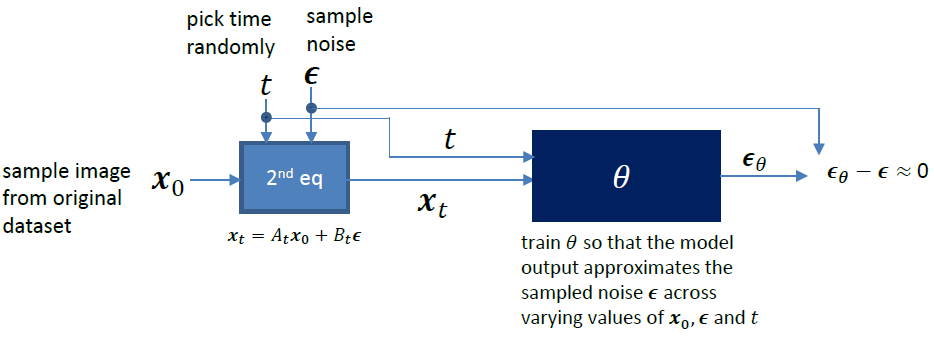

In [ ]:
from typing import Dict, Tuple
from tqdm import tqdm
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import models, transforms
from torchvision.datasets import MNIST
from torchvision.utils import save_image, make_grid
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation, PillowWriter
import numpy as np

### **1. Define a model architecture**

We will use an architecture called *U-net* for $\boldsymbol{\epsilon}_{\theta}(\cdot)$, which is widely adopted in current diffusion model literature.

In [ ]:
class ResidualConvBlock(nn.Module):
    def __init__(
        self, in_channels: int, out_channels: int, is_res: bool = False
    ) -> None:
        super().__init__()
        '''
        standard ResNet style convolutional block
        '''
        self.same_channels = in_channels==out_channels
        self.is_res = is_res
        self.conv1 = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, 3, 1, 1),
            nn.BatchNorm2d(out_channels),
            nn.GELU(),
        )
        self.conv2 = nn.Sequential(
            nn.Conv2d(out_channels, out_channels, 3, 1, 1),
            nn.BatchNorm2d(out_channels),
            nn.GELU(),
        )

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        if self.is_res:
            x1 = self.conv1(x)
            x2 = self.conv2(x1)
            # this adds on correct residual in case channels have increased
            if self.same_channels:
                out = x + x2
            else:
                out = x1 + x2 
            return out / 1.414
        else:
            x1 = self.conv1(x)
            x2 = self.conv2(x1)
            return x2


class UnetDown(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(UnetDown, self).__init__()
        '''
        process and downscale the image feature maps
        '''
        layers = [ResidualConvBlock(in_channels, out_channels), nn.MaxPool2d(2)]
        self.model = nn.Sequential(*layers)

    def forward(self, x):
        return self.model(x)


class UnetUp(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(UnetUp, self).__init__()
        '''
        process and upscale the image feature maps
        '''
        layers = [
            nn.ConvTranspose2d(in_channels, out_channels, 2, 2),
            ResidualConvBlock(out_channels, out_channels),
            ResidualConvBlock(out_channels, out_channels),
        ]
        self.model = nn.Sequential(*layers)

    def forward(self, x, skip):
        x = torch.cat((x, skip), 1)
        x = self.model(x)
        return x


class EmbedFC(nn.Module):
    def __init__(self, input_dim, emb_dim):
        super(EmbedFC, self).__init__()
        '''
        generic one layer FC NN for embedding things  
        '''
        self.input_dim = input_dim
        layers = [
            nn.Linear(input_dim, emb_dim),
            nn.GELU(),
            nn.Linear(emb_dim, emb_dim),
        ]
        self.model = nn.Sequential(*layers)

    def forward(self, x):
        x = x.view(-1, self.input_dim)
        return self.model(x)


class ContextUnet(nn.Module):
    def __init__(self, in_channels, n_feat = 256, n_classes=10):
        super(ContextUnet, self).__init__()

        self.in_channels = in_channels
        self.n_feat = n_feat
        self.n_classes = n_classes

        self.init_conv = ResidualConvBlock(in_channels, n_feat, is_res=True)

        self.down1 = UnetDown(n_feat, n_feat)
        self.down2 = UnetDown(n_feat, 2 * n_feat)

        self.to_vec = nn.Sequential(nn.AvgPool2d(7), nn.GELU())

        self.timeembed1 = EmbedFC(1, 2*n_feat)
        self.timeembed2 = EmbedFC(1, 1*n_feat)
        self.contextembed1 = EmbedFC(n_classes, 2*n_feat)
        self.contextembed2 = EmbedFC(n_classes, 1*n_feat)

        self.up0 = nn.Sequential(
            nn.ConvTranspose2d(2 * n_feat, 2 * n_feat, 7, 7), # otherwise just have 2*n_feat
            nn.GroupNorm(8, 2 * n_feat),
            nn.ReLU(),
        )

        self.up1 = UnetUp(4 * n_feat, n_feat)
        self.up2 = UnetUp(2 * n_feat, n_feat)
        self.out = nn.Sequential(
            nn.Conv2d(2 * n_feat, n_feat, 3, 1, 1),
            nn.GroupNorm(8, n_feat),
            nn.ReLU(),
            nn.Conv2d(n_feat, self.in_channels, 3, 1, 1),
        )

    def forward(self, x, t):
        # x is (noisy) image, t is timestep, 
        x = self.init_conv(x)
        down1 = self.down1(x)
        down2 = self.down2(down1)
        hiddenvec = self.to_vec(down2)
        
        # embed  time step
        temb1 = self.timeembed1(t).view(-1, self.n_feat * 2, 1, 1)
        temb2 = self.timeembed2(t).view(-1, self.n_feat, 1, 1)

        up1 = self.up0(hiddenvec)
        up2 = self.up1(up1 + temb1, down2)  # add embeddings
        up3 = self.up2(up2 + temb2, down1)
        out = self.out(torch.cat((up3, x), 1))
        return out

### **2. Scheduling $\beta_t$ for whole time steps $t=0, 1, \dots, T$**

- As done in the paper, titled "Denoising Diffusion Probabilistic Models" (https://arxiv.org/abs/2006.11239), we increase $\beta_t$ linearly from $1e-4$ to $0.02$.
- Here we set $T$ as 500.

In [ ]:
beta1 = 1e-4
beta2 = 0.02
T = 500

beta_t = (beta2 - beta1) * torch.arange(0, T + 1, dtype=torch.float32) / T + beta1
beta_t = beta_t.cuda()
print(beta_t)

tensor([1.0000e-04, 1.3980e-04, 1.7960e-04, 2.1940e-04, 2.5920e-04, 2.9900e-04,
        3.3880e-04, 3.7860e-04, 4.1840e-04, 4.5820e-04, 4.9800e-04, 5.3780e-04,
        5.7760e-04, 6.1740e-04, 6.5720e-04, 6.9700e-04, 7.3680e-04, 7.7660e-04,
        8.1640e-04, 8.5620e-04, 8.9600e-04, 9.3580e-04, 9.7560e-04, 1.0154e-03,
        1.0552e-03, 1.0950e-03, 1.1348e-03, 1.1746e-03, 1.2144e-03, 1.2542e-03,
        1.2940e-03, 1.3338e-03, 1.3736e-03, 1.4134e-03, 1.4532e-03, 1.4930e-03,
        1.5328e-03, 1.5726e-03, 1.6124e-03, 1.6522e-03, 1.6920e-03, 1.7318e-03,
        1.7716e-03, 1.8114e-03, 1.8512e-03, 1.8910e-03, 1.9308e-03, 1.9706e-03,
        2.0104e-03, 2.0502e-03, 2.0900e-03, 2.1298e-03, 2.1696e-03, 2.2094e-03,
        2.2492e-03, 2.2890e-03, 2.3288e-03, 2.3686e-03, 2.4084e-03, 2.4482e-03,
        2.4880e-03, 2.5278e-03, 2.5676e-03, 2.6074e-03, 2.6472e-03, 2.6870e-03,
        2.7268e-03, 2.7666e-03, 2.8064e-03, 2.8462e-03, 2.8860e-03, 2.9258e-03,
        2.9656e-03, 3.0054e-03, 3.0452e-

### **3. Obtain the list of $\sqrt{\bar{\alpha}_t}$ and $\sqrt{1-\bar{\alpha}_t}$ for $t=0, 1, \dots, T$, which will be used in forward process:**

$$\boldsymbol{x}_t = \sqrt{\bar{\alpha}_t}\boldsymbol{x}_0 + \sqrt{1-\bar{\alpha}_t}\boldsymbol{\epsilon}$$

In [ ]:
sqrt_beta_t = torch.sqrt(beta_t)
alpha_t = 1 - beta_t

log_alpha_t = torch.log(alpha_t)
alphabar_t = torch.cumsum(log_alpha_t, dim=0).exp()
sqrtab = torch.sqrt(alphabar_t)        # \sqrt{\bar{\alpha}_t}
sqrtmab = torch.sqrt(1 - alphabar_t)   # \sqrt{1-\bar{\alpha}_t}

### **4. Implement forward process**

For training the model defined with $\boldsymbol{\epsilon}_{\boldsymbol{\theta}}\left(\sqrt{\bar{\alpha}_t} \boldsymbol{x}_0 + \sqrt{1-\bar{\alpha}_t}\boldsymbol{\epsilon}, t\right)$, we need to get $\sqrt{\bar{\alpha}_t} \boldsymbol{x}_0 + \sqrt{1-\bar{\alpha}_t}\boldsymbol{\epsilon}$ where $t$ is uniformly sampled from $\text{Uniform}(1, 2, \dots, T)$ distribution.

Note that the shape of $x$ is $(\text{batchsize, in_channels, height, width})=(\text{batchsize}, 1, 28, 28)$ and the shape of `_ts` defined below is initially $(\text{batchsize,})$. Based on this, you need to match the shape of them (along with `sqrtab` and `sqrtmab` as well).

In [ ]:
def forward_process(x):
    """
    this method is used in training, so samples t and noise randomly
    """
    _ts = torch.randint(1, T+1, (x.shape[0],)).to(x.device)  # t ~ Uniform(0, n_T)
    noise = torch.randn_like(x)  # eps ~ N(0, 1)

    x_t = sqrtab[_ts].reshape(-1, 1, 1, 1) * x + sqrtmab[_ts].reshape(-1, 1, 1, 1) * noise    # This is the x_t, which is sqrt(alphabar) x_0 + sqrt(1-alphabar) * eps
    return x_t, noise, _ts

### **5. Training the model**

In [ ]:
n_epoch = 5
batch_size = 128
device = "cuda:0"
n_classes = 5
n_feat = 128
lrate = 1e-4

epsilon_model = ContextUnet(in_channels=1, n_feat=n_feat, n_classes=n_classes)
epsilon_model.to(device)

tf = transforms.Compose([transforms.ToTensor()]) # mnist is already normalised 0 to 1

train_dataset = MNIST("./data", train=True, download=True, transform=tf)
idx =  (train_dataset.targets==0) |  (train_dataset.targets==1) | (train_dataset.targets==2)
train_dataset.targets =train_dataset.targets[idx]
train_dataset.data = train_dataset.data[idx]
dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
optim = torch.optim.Adam(epsilon_model.parameters(), lr=lrate)
loss_mse = nn.MSELoss()

for ep in range(n_epoch):
    print(f'epoch {ep}')
    epsilon_model.train()

    # linear lrate decay
    optim.param_groups[0]['lr'] = lrate*(1-ep/n_epoch)

    pbar = tqdm(dataloader)
    loss_ema = None
    for x_0, target in pbar:
        optim.zero_grad()
        x_0 = x_0.to(device)

        x_t, noise, _ts = forward_process(x_0)
        eps_theta = epsilon_model(x_t, _ts / T)
        loss = loss_mse(eps_theta, noise)
        loss.backward()
        
        if loss_ema is None:
            loss_ema = loss.item()
        else:
            loss_ema = 0.95 * loss_ema + 0.05 * loss.item()
        pbar.set_description(f"loss: {loss_ema:.4f}")
        optim.step()

epoch 0


loss: 0.0552: 100%|██████████| 146/146 [00:37<00:00,  3.91it/s]


epoch 1


loss: 0.0389: 100%|██████████| 146/146 [00:35<00:00,  4.14it/s]


epoch 2


loss: 0.0362: 100%|██████████| 146/146 [00:34<00:00,  4.22it/s]


epoch 3


loss: 0.0324: 100%|██████████| 146/146 [00:35<00:00,  4.16it/s]


epoch 4


loss: 0.0316: 100%|██████████| 146/146 [00:34<00:00,  4.20it/s]


### **6. Sampling stage for image generation**

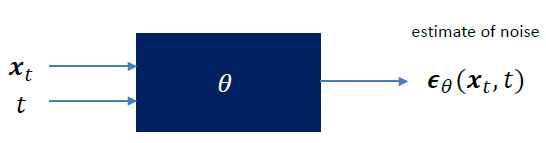



Here we sample $\boldsymbol{x}_{t-1}$ given $\boldsymbol{x}_t$, starting from $\boldsymbol{x}_T \sim \mathcal{N}(0, \mathbf{I})$ to $\boldsymbol{x}_0$ consecutively for generating the image based on the following learned distribution.

$$p_{\boldsymbol{\theta}}\left(\boldsymbol{x}_{t-1} \mid \boldsymbol{x}_t\right) = \mathcal{N}\left(\frac{1}{\sqrt{\alpha_t}}\left(\boldsymbol{x}_t-\frac{1-\alpha_t}{\sqrt{1-\bar{\alpha}_t}} \boldsymbol{\epsilon}_{\theta}(\boldsymbol{x}_t, t)\right) , \frac{\left(1-\alpha_t\right)\left(1-\bar{\alpha}_{t-1}\right)}{1-\bar{\alpha}_t} \mathbf{I} \right)$$

In other words, starting from $\boldsymbol{x}_T \sim \mathcal{N}(0, \mathbf{I})$ we conduct reverse process as follows.




**for** $t=T, \dots, 1$ **do**

$~~~~~$ $\boldsymbol{z} \sim \mathcal{N}(0, \mathbf{I})~$ if $t>1,$ else $~\boldsymbol{z}=0$

$~~~~~$ $\boldsymbol{x}_{t-1} = \frac{1}{\sqrt{\alpha_t}}\left(\boldsymbol{x}_t-\frac{1-\alpha_t}{\sqrt{1-\bar{\alpha}_t}} \boldsymbol{\epsilon}_{\theta}(\boldsymbol{x}_t, t)\right) + \sigma_t\boldsymbol{z}$

where we set $\sigma_t=\sqrt{\frac{\left(1-\alpha_t\right)\left(1-\bar{\alpha}_{t-1}\right)}{1-\bar{\alpha}_t}}≈\sqrt{1-\alpha_t}=\sqrt{\beta_t}$

In [ ]:
def sampling(eps_model, n_sample, size, T, device):
    x_i = torch.randn(n_sample, *size).to(device)  # x_T ~ N(0, 1), sample initial noise
    x_i_store = [] # keep track of generated steps in case want to plot something 

    for i in range(T, 0, -1):
        print(f'sampling timestep {i}',end='\r')
        t_is = torch.tensor([i]).to(device)
        t_is = t_is.repeat(n_sample, 1, 1, 1)
        z = torch.randn(n_sample, *size).to(device) if i > 1 else 0

        eps = eps_model(x_i, t_is / T)
        x_i = 1 / torch.sqrt(alpha_t)[i] * (x_i - (1 - alpha_t[i]) / sqrtmab[i] * eps) + torch.sqrt(beta_t)[i] * z
        if i%20==0 or i==T or i<8:
            x_i_store.append(x_i.detach().cpu().numpy())
    
    x_i_store = np.array(x_i_store)
    return x_i, x_i_store

### **7. Visualization**

saved image at generated_images.png


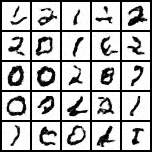

In [ ]:
from IPython.display import Image, display

# for eval, save an image of currently generated samples (top rows)
# followed by real images (bottom rows)
epsilon_model.eval()
with torch.no_grad():
    n_sample = 25
    x_gen, x_gen_store = sampling(epsilon_model, n_sample, (1, 28, 28), T, device)

    x_all = torch.cat([x_gen])
    grid = make_grid(x_all*-1 + 1, nrow=5)
    save_image(grid,  "generated_images.png")
    print('saved image at ' + "generated_images.png")
    display(Image('generated_images.png', width=250, height=250))

Although the generated images may initially be of poor quality, high-quality images can be produced  with sufficient training time.

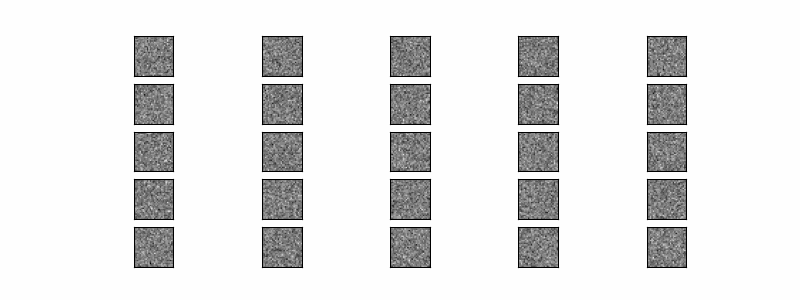

In [ ]:
# create gif of images evolving over time, based on x_gen_store
with torch.no_grad():
    fig, axs = plt.subplots(nrows=int(n_sample/n_classes), ncols=n_classes,sharex=True,sharey=True,figsize=(8,3))
    def animate_diff(i, x_gen_store):
        print(f'gif animating frame {i} of {x_gen_store.shape[0]}', end='\r')
        plots = []
        for row in range(int(n_sample/n_classes)):
            for col in range(n_classes):
                axs[row, col].clear()
                axs[row, col].set_xticks([])
                axs[row, col].set_yticks([])
                # plots.append(axs[row, col].imshow(x_gen_store[i,(row*n_classes)+col,0],cmap='gray'))
                plots.append(axs[row, col].imshow(-x_gen_store[i,(row*n_classes)+col,0],cmap='gray',vmin=(-x_gen_store[i]).min(), vmax=(-x_gen_store[i]).max()))
        return plots
    ani = FuncAnimation(fig, animate_diff, fargs=[x_gen_store],  interval=200, blit=False, repeat=True, frames=x_gen_store.shape[0])    
    ani.save("gif.gif", dpi=100, writer=PillowWriter(fps=5))
    plt.close()
display(Image("gif.gif"))

## **(Optional) Use Pretrained Diffusion Model for Generating High-quality Images with Prompt**

In [ ]:
%pip install --quiet --upgrade diffusers transformers accelerate mediapy triton scipy ftfy spacy torch

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 934.9/934.9 kB 38.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.1/7.1 MB 106.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 219.1/219.1 kB 25.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.3/63.3 MB 11.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.1/53.1 kB 7.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.6/6.6 MB 107.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 224.5/224.5 kB 24.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 117.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 89.6 MB/s eta 0:00:00


In [ ]:
# The xformers package is mandatory to be able to create several 768x768 images.
%pip install -q xformers

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 109.1/109.1 MB 8.7 MB/s eta 0:00:00


In [ ]:
import mediapy as media
import torch
from diffusers import StableDiffusionPipeline
import random

model_id = "dreamlike-art/dreamlike-photoreal-2.0"
scheduler = None

device = "cuda"

if model_id.startswith("stabilityai/"):
  model_revision = "fp16"
else:
  model_revision = None

if scheduler is None:
  pipe = StableDiffusionPipeline.from_pretrained(
      model_id,
      torch_dtype=torch.float16,
      revision=model_revision,
      )  
else:
  pipe = StableDiffusionPipeline.from_pretrained(
      model_id,
      scheduler=scheduler,
      torch_dtype=torch.float16,
      revision=model_revision,
      )

pipe = pipe.to(device)
pipe.enable_xformers_memory_efficient_attention()

if model_id.endswith('-base'):
  image_length = 512
else:
  image_length = 768

Fetching 12 files:   0%|          | 0/12 [00:00<?, ?it/s]

### **Feel free to write any sentence representing the image you want to generate in the prompt.**

  0%|          | 0/50 [00:00<?, ?it/s]


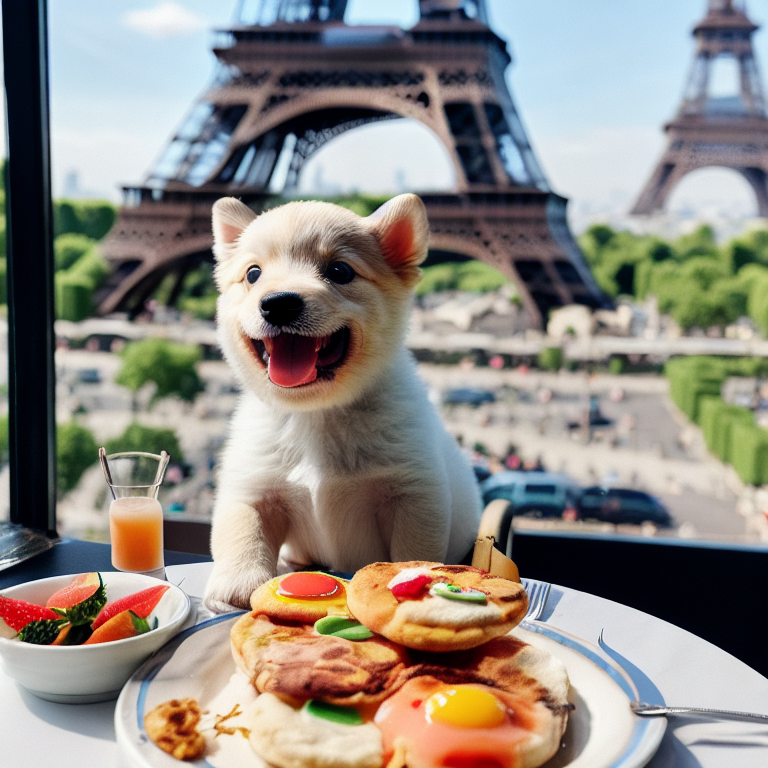
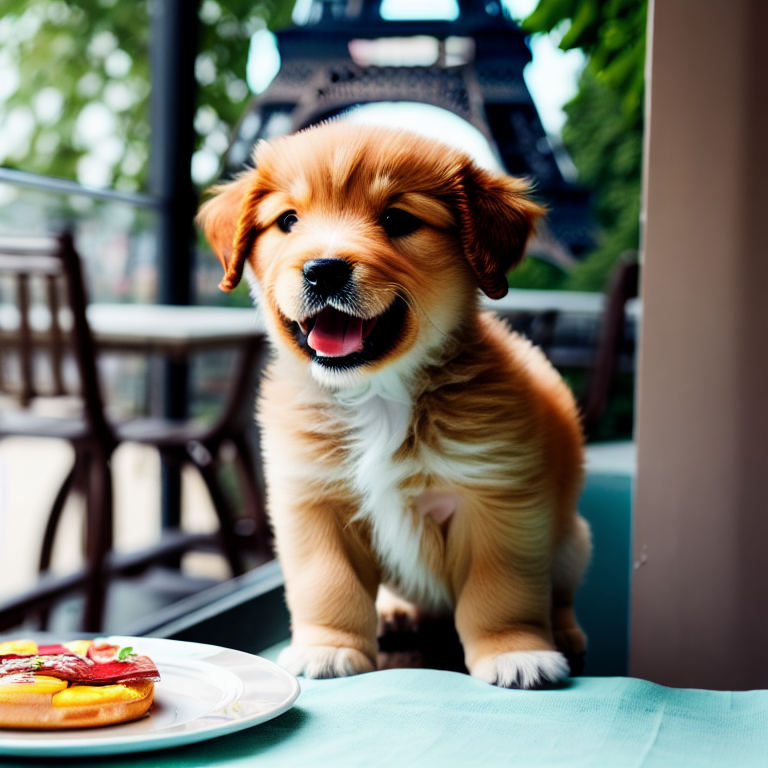
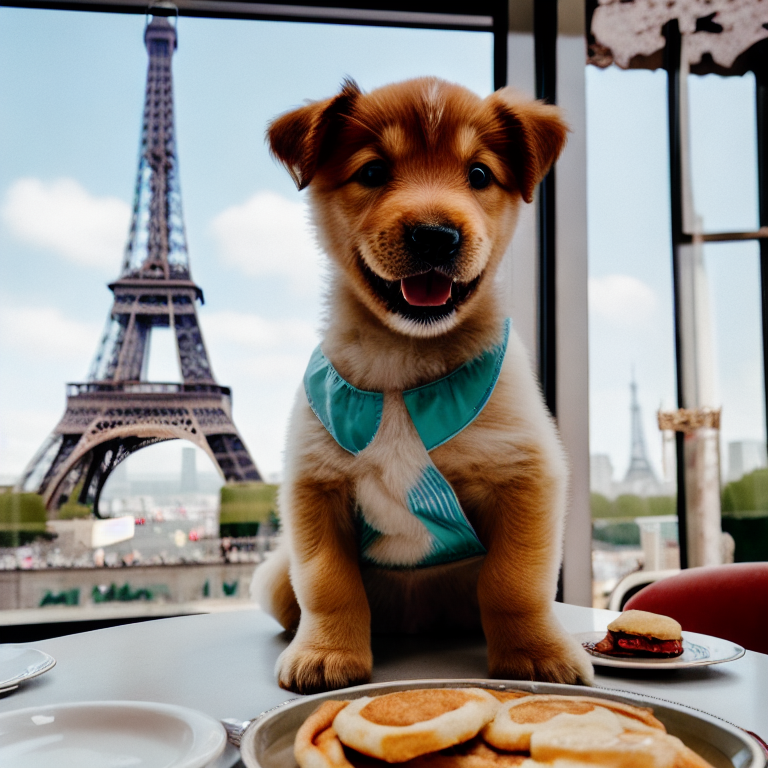
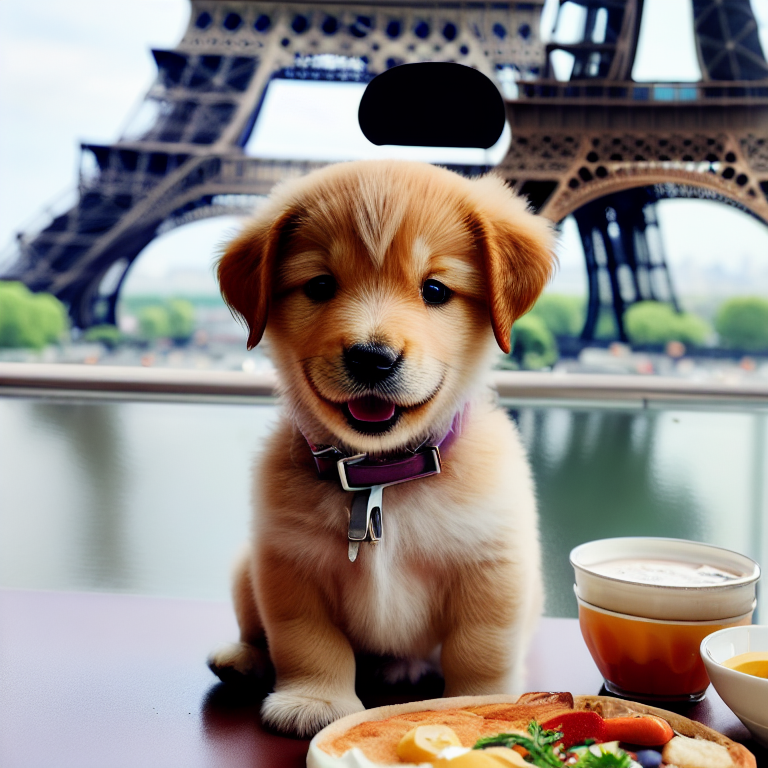

'Seed: 1000'

In [ ]:
prompt = "a photo of puppy with happy expression, having a brunch with a view to the Eiffel Tower"
num_images = 4
seed = 1000

images = pipe(
    prompt,
    height = image_length,
    width = image_length,
    num_inference_steps = 50,
    guidance_scale = 9,
    num_images_per_prompt = num_images,
    generator = torch.Generator("cuda").manual_seed(seed)
    ).images
    
media.show_images(images)
display(f"Seed: {seed}")
images[0].save("output.jpg")

## **References**

https://github.com/TeaPearce/Conditional_Diffusion_MNIST
https://github.com/bot66/MNISTDiffusion

https://github.com/FengNiMa/pytorch_diffusion_model_celebahq

https://github.com/zoubohao/DenoisingDiffusionProbabilityModel-ddpm-

https://arxiv.org/abs/2208.11970

https://arxiv.org/abs/2006.11239

https://github.com/woctezuma/stable-diffusion-colab